In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using Optim
import ProgressMeter


In [2]:
import ReactiveMP.messageout

In [3]:
include("../helpers/data.jl")

generate_data

In [4]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [5]:
data_seed, params_seed = 42, 120

(42, 120)

In [6]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [7]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), 1e12*diageye(h_order)))}  
    w       = randomvar()
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    Ys = [Y*y_prev[i] for i in 1:n]
    Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Multivariate, h_order, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(order))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [8]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)),
                                    w_prior=(0.1, 1.0), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior, w_prior,
                                                                               observations_prev, controls,
                                                                               y_order, u_order, h_order,
                                                                               options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [9]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [11]:
Random.seed!(data_seed)

n_samples = 100
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [12]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

108-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-1.7201456159712687, 1.1388232170825652]
 [-2.997620502559061, -1.7201456159712687]
 [-1.5190969233292764, -2.997620502559061]
 [1.3560773615350517, -1.5190969233292764]
 [2.9844803740752193, 1.3560773615350517]
 [1.8689658943270464, 2.9844803740752193]
 [-0.9648672094875927, 1.8689658943270464]
 [-2.911605850612454, -0.9648672094875927]
 [-2.181427500242558, -2.911605850612454]
 [0.5543452336820024, -

In [20]:
train_size = 80
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

In [21]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = randn(flow_param_len)

45-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
  ⋮
 -0.27993479669913585
 -0.8271189269423392
 -1.2688151069939353
  0.5442892692759611
  0.9515135579177358
 -2.2502731970794416
 -1.8241177727907605
  0.5887138745053259
  0.6765822621496003
  0.29873821278434554
  0.35665768910493706
 -0.5512200526575644

In [22]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, w_prior=(1e4, 1e0), y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=5);


In [23]:
inv(mean(w_))

0.02559174092334107

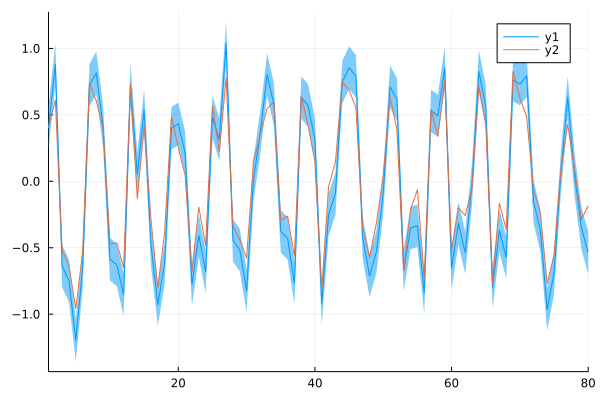

In [24]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

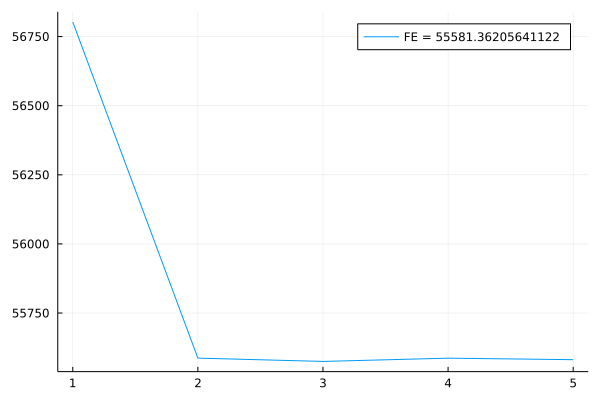

In [25]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [47]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, params,
                                                             y_order=order_y, u_order=order_u, h_order=order_h,
                                                             h_prior=(zeros(order_h), 0.1*diageye(order_h)),
                                                             w_prior=(1e-4, 1e-4), vmp_its=5)
    return fe[end]
end;

In [48]:
using ForwardDiff
@time ForwardDiff.gradient(FE, model_params)

  0.581112 seconds (2.13 M allocations: 684.018 MiB, 29.66% gc time, 4.55% compilation time)


45-element Vector{Float64}:
   2.652429585119826
  -2.3652412788259554
   0.5919736156869924
  -2.208940399893333
   0.07935017674308753
   1.5952160263753683
  -1.7500783529765058
  -1.251930216460897
   1.906104155782316
 -13.503254999462357
  -2.463735542631891
  -0.12188275241479074
   1.6838984968425166
   ⋮
  -6.431855653831629
  -2.0777780197557973
   0.7419069252683261
   0.43786702349320117
   0.0010992250221656397
  -0.002478635872517676
   3.2480507529098546
   0.41062639547108404
   0.42298804080541474
   3.272804572120954
   1.386683381059207
   0.16164029819441694

In [19]:
# NOTE: run in case of emergency
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [23]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_mv_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

Dict{String, Any} with 1 entry:
  "inf_params" => [-0.817088, 1.09741, 0.492251, -0.847422, -0.730305, -0.10849…

In [49]:
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     3.617665e+02     1.579973e+01
 * time: 0.000141143798828125
    10     2.599039e+02     4.137958e+02
 * time: 17.120192050933838
    20     2.366756e+02     2.788765e+02
 * time: 29.522409915924072
    30     2.209416e+02     2.501920e+02
 * time: 42.959636926651
    40     2.182140e+02     1.768238e+02
 * time: 61.23159408569336
    50     2.075899e+02     9.075002e+01
 * time: 76.792475938797
    60     2.008453e+02     2.188987e+02
 * time: 88.02704501152039
    70     1.753454e+02     5.280418e+02
 * time: 102.22693204879761
    80     1.720962e+02     2.812848e+02
 * time: 117.04873514175415
    90     1.678069e+02     5.203240e+01
 * time: 130.75634002685547
   100     1.600350e+02     2.611351e+02
 * time: 144.36744093894958
   110     1.520335e+02     1.819400e+02
 * time: 156.89674305915833
   120     1.384538e+02     1.627671e+03
 * time: 168.60884714126587
   130     1.289956e+02     8.750926e+02
 * time: 181.62801909446716

 * Status: success

 * Candidate solution
    Final objective value:     9.482292e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.46e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   470  (vs limit Inf)
    Iterations:    202
    f(x) calls:    943
    ∇f(x) calls:   943


In [50]:
inf_params = Optim.minimizer(res)


45-element Vector{Float64}:
 -2.9342285202864438
  2.2162495503420945
 -0.6055563769092839
 -0.738979041330583
  1.5612976606679279
  0.6622398398548621
  3.7732941956507218
 -1.1399597024740278
 -0.23338571373875672
  6.067543660384688
 -0.33502436571522604
  0.07220415695135168
  0.2748025921917736
  ⋮
  1.304995666506997
  0.7852590794316039
 -1.1675861128509546
 -1.4560718161888901
  1.335317288969269
 -2.5580544651106467
 -3.5683068405424523
  0.5516946632542287
  0.4995048133475374
 -0.8578390431740861
 -0.39802908890855626
 -0.7867372860080253

In [486]:
using JLD
JLD.save("../dump/flow_mv_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [51]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params,
                                                                y_order=order_y, u_order=order_u, h_order=order_h,
                                                                h_prior=(zeros(order_h), 0.1*diageye(order_h)),
                                                                w_prior=(1e3, 1.0), vmp_its=10);


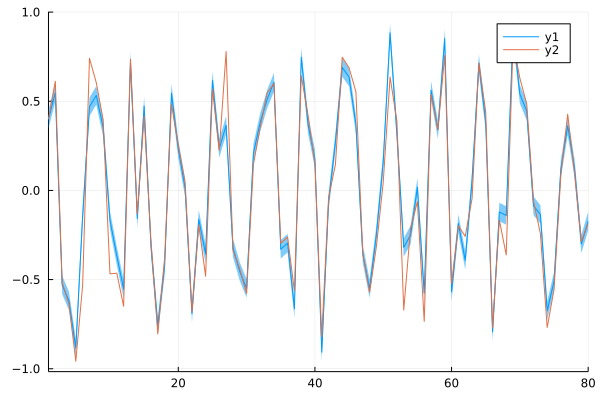

In [52]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

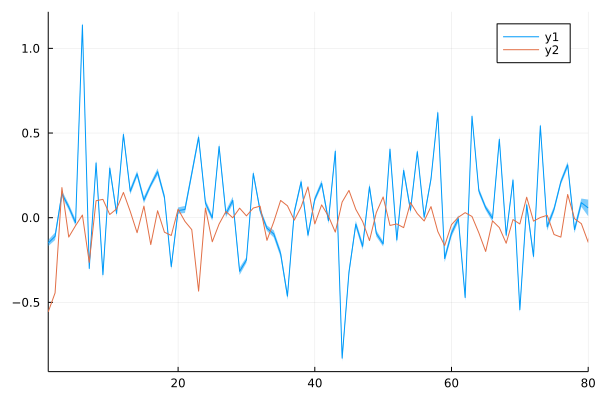

In [55]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))),  xlims=(1, 80))
plot!(h_gen)

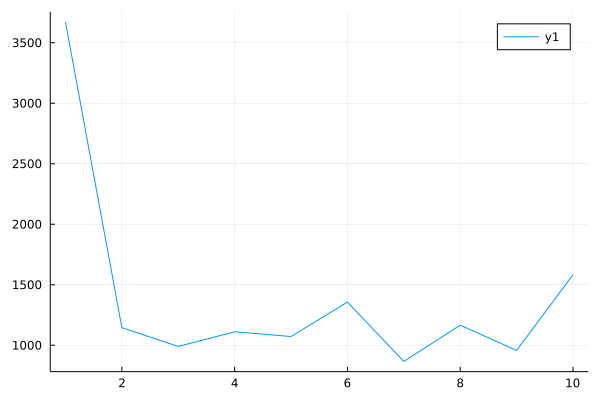

In [56]:
plot(fe_)

### KF-like prediction

In [57]:
function transition(γ, order)
    V = zeros(order, order)
#     V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [58]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, h_prior, w, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(full_order))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [59]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, h_prior, w,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y_lat_2), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [76]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, h_prior=h_prev, w_prior=(shape(w_), rate(w_)), vmp_its=5);
    h_prev = (mean.(h_inf)[end], precision.(h_inf)[end])
    
end

In [77]:
mx, vx = mean.(predictions), cov.(predictions);

In [78]:
test_from, test_to = 1, 20

(1, 20)

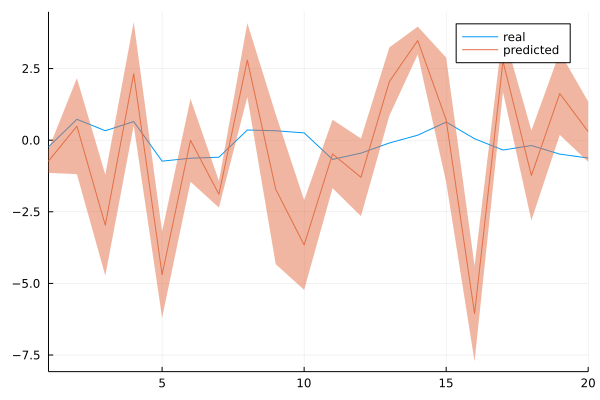

In [79]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")

In [46]:
X_test

20-element Vector{Vector{Float64}}:
 [-0.18455019799056774, -0.28746002317330044]
 [-0.23318497939282093, -0.18455019799056774]
 [0.7290521833218151, -0.23318497939282093]
 [0.32953105629942264, 0.7290521833218151]
 [0.650411090402282, 0.32953105629942264]
 [-0.731784677644634, 0.650411090402282]
 [-0.6296770215703945, -0.731784677644634]
 [-0.5950991925763538, -0.6296770215703945]
 [0.3556239920806319, -0.5950991925763538]
 [0.3291061215450151, 0.3556239920806319]
 [0.2548595613396384, 0.3291061215450151]
 [-0.6712899768434482, 0.2548595613396384]
 [-0.4522340395629772, -0.6712899768434482]
 [-0.09734518990959494, -0.4522340395629772]
 [0.17490451870116086, -0.09734518990959494]
 [0.6328135501474206, 0.17490451870116086]
 [0.04992924828999329, 0.6328135501474206]
 [-0.3441263371213172, 0.04992924828999329]
 [-0.18672916626126834, -0.3441263371213172]
 [-0.48686064458100603, -0.18672916626126834]